In [1]:
import torch

if torch.cuda.is_available():
    print("GPU trouvé :", torch.cuda.get_device_name(0))
else:
    print("Aucun GPU trouvé, utilisation du CPU.")


GPU trouvé : Tesla P100-PCIE-16GB


In [2]:
# pytorch mlp for binary classification
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from tqdm import tqdm

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
print(os.listdir('../input/nyse'))

['prices-split-adjusted.csv', 'fundamentals.csv', 'prices.csv', 'securities.csv']


In [5]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis=1)
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [6]:

# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plotCorrelationMatrix(df, graphWidth):
    # Check if the dataframe has a name attribute; otherwise, set a default name
    filename = getattr(df, 'dataframeName')
    
    # Drop columns with NaN values and keep columns with more than one unique value
    df = df.dropna(axis=1)
    df = df[[col for col in df if df[col].nunique() > 1]]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])

    # If there are fewer than 2 numeric columns, exit
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant numeric columns ({df.shape[1]}) is less than 2')
        return

    # Calculate correlation matrix
    corr = df.corr()

    # Plot correlation matrix with annotations
    plt.figure(figsize=(graphWidth, graphWidth))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': .8})
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


Let's check 1st file: ../input/fundamentals.csv


In [8]:

# fundamentals.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('../input/nyse/fundamentals.csv', delimiter=',')
df1.dataframeName = 'fundamentals.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1781 rows and 79 columns


In [9]:
df1.head()

Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09     1.059200e+10        75.0  ...   
2         -5.311000e+09     1.513500e+10        60.0  ...   
3         -6.151000e+09     1.159100e+10        51.0  ...   
4         -2.711820e+08     5.202150e+08        23.0  ...   

   Total Current Assets  Total Current Liabilities  Total Equity  \
0          7.072000e+09               9.011000e+09 -7.987000e+09   
1          1.432300e+10               1.380600e+10 -2.731000e+09   
2          1.175000e+10               1.340400e+10  2.021000e+09   
3          9.985000e+09               1.360500e+10  5.635000e+09   
4          3.184200e+09               2.559638e+09  1.210694e+09   

   Total Liabilities  Total Liabilities & Equity  Total Revenue  \
0       2.489100e+10                1.690400e+10   2.485500e+10   
1       4.500900e+10                4.227800e+10   2.674300e+10   
2       4.120400e+10                4.322500e+10   4.265000e+10   
3       4.278000e+10                4.841500e+10   4.099000e+10   
4       3.403120e+09                4.613814e+09   6.205003e+09   

   Treasury Stock  For Year  Earnings Per Share  Estimated Shares Outstanding  
0    -367000000.0    2012.0               -5.60                  3.350000e+08  
1             0.0    2013.0              -11.25                  1.630222e+08  
2             0.0    2014.0                4.02                  7.169154e+08  
3             0.0    2015.0               11.39                  6.681299e+08  
4     -27095000.0    2012.0                5.29                  7.328355e+07  

[5 rows x 79 columns]

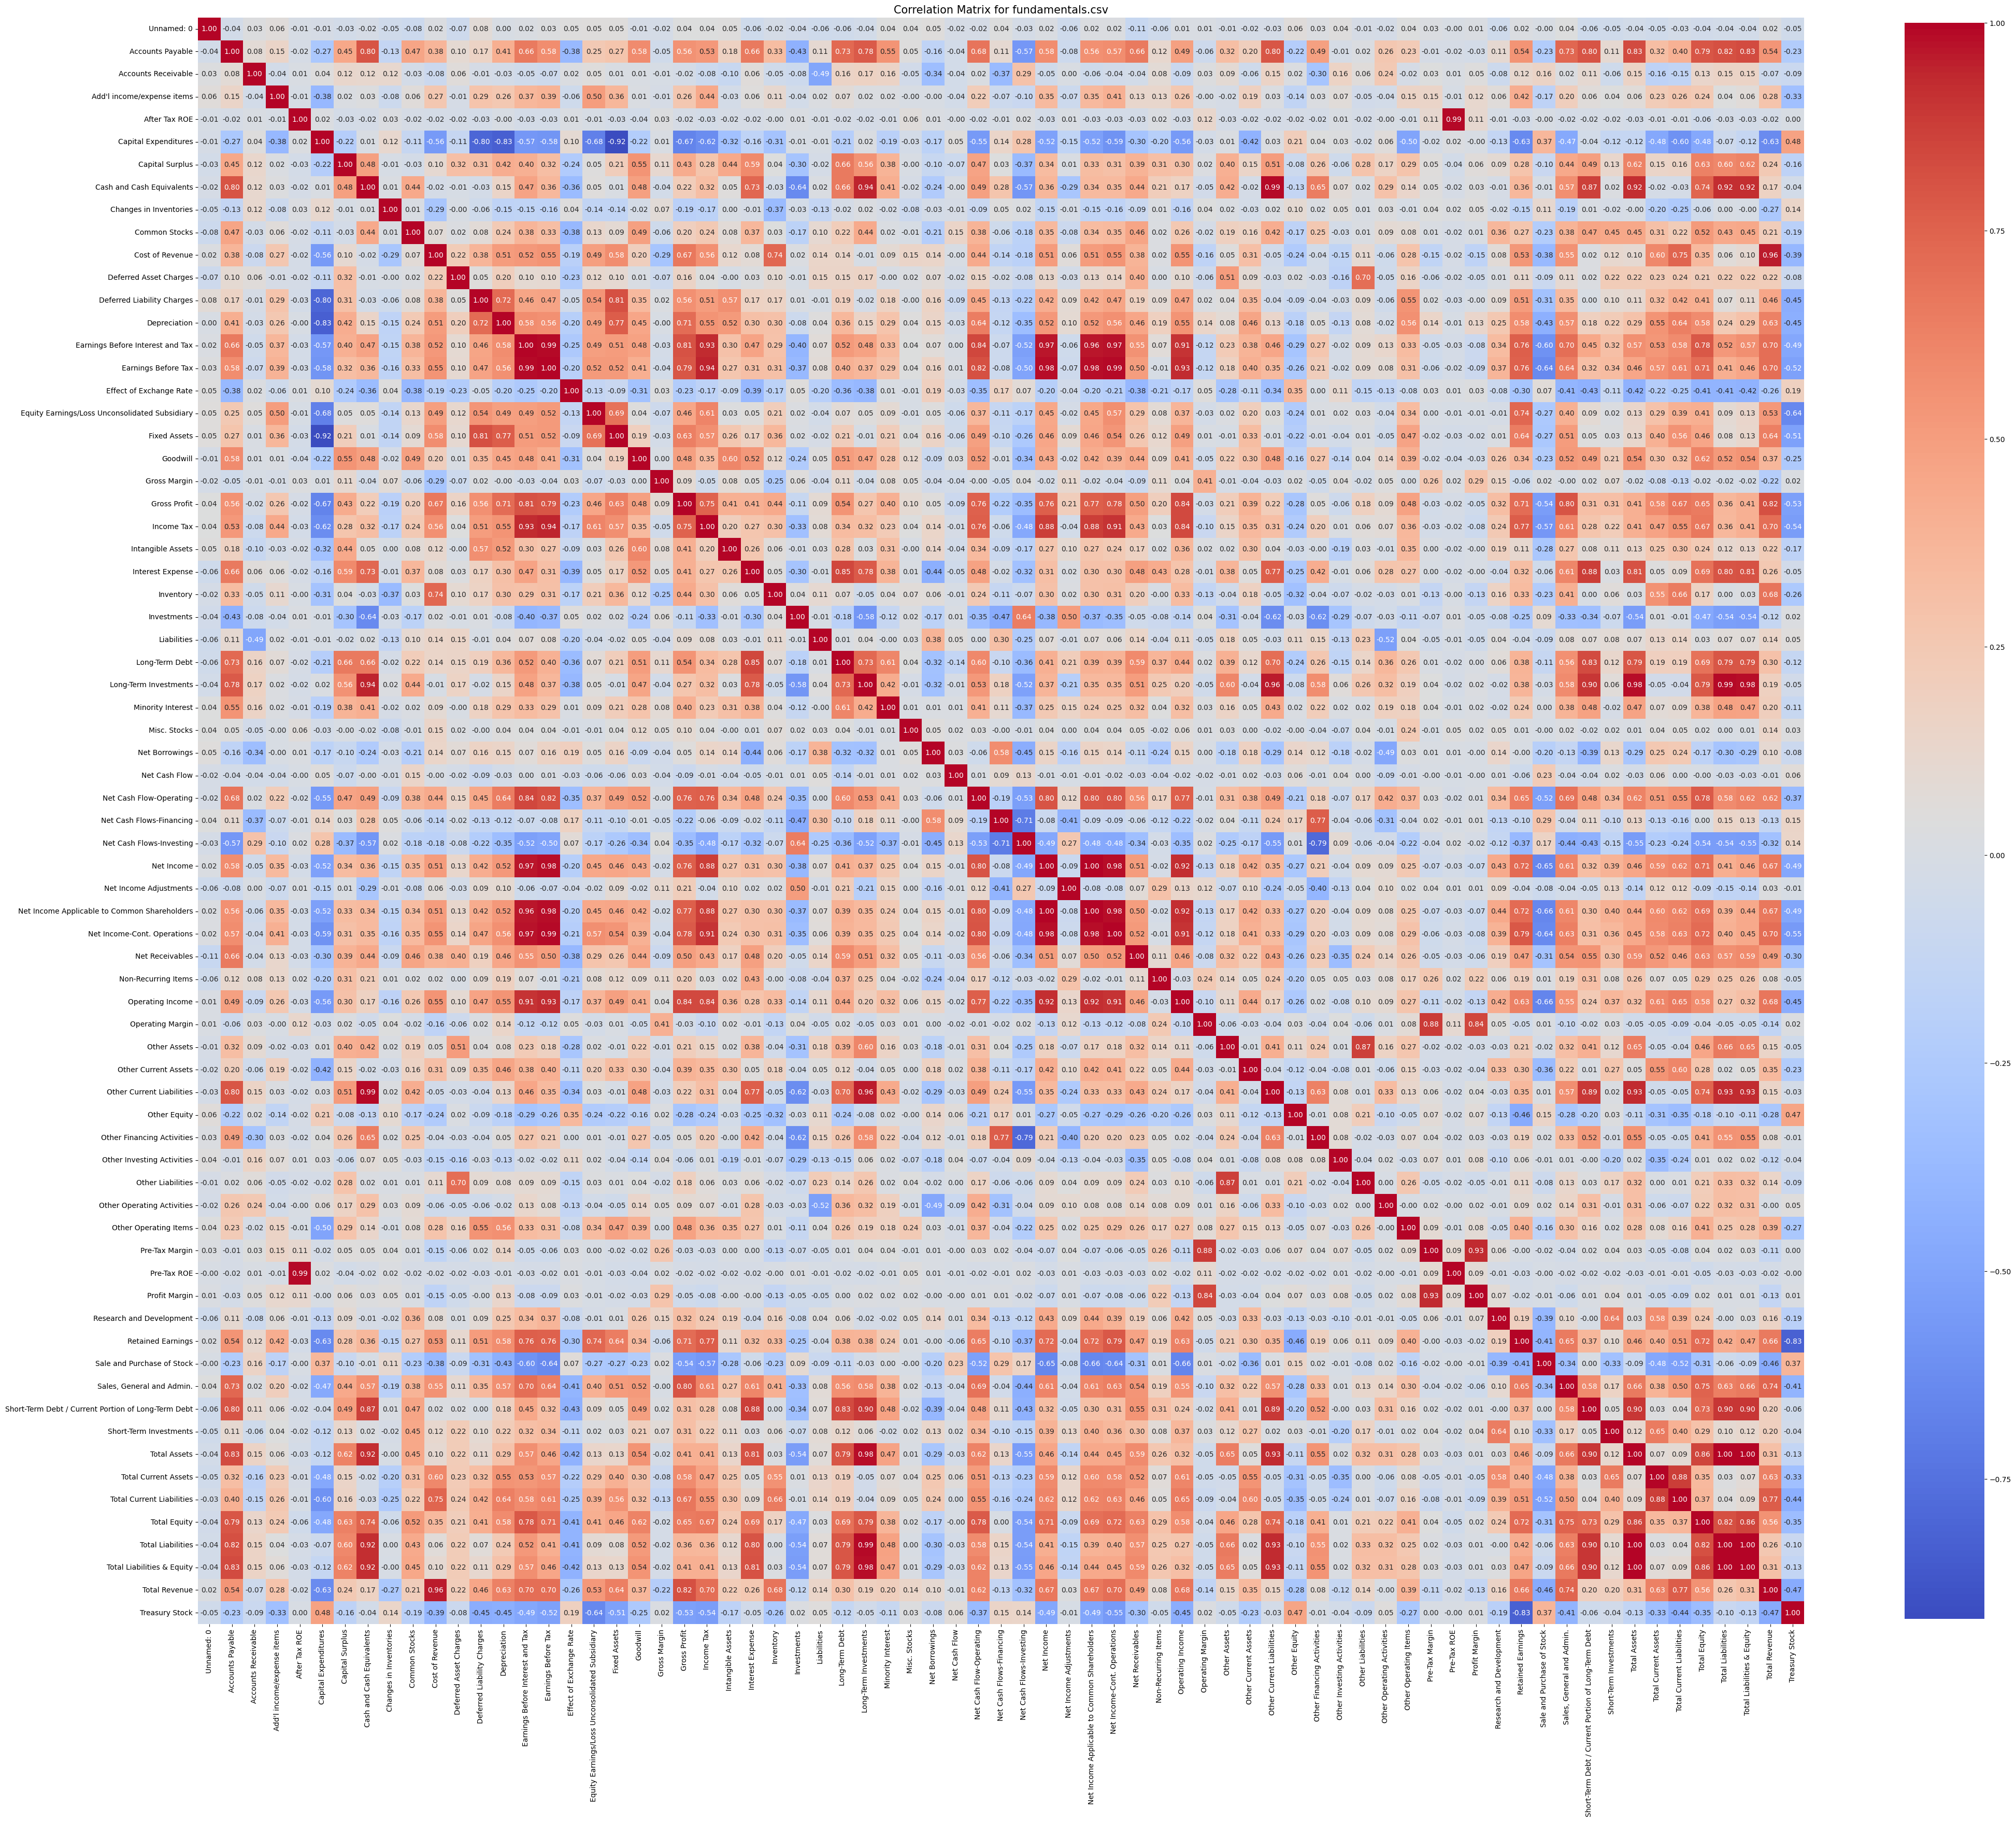

In [10]:
plotCorrelationMatrix(df1, 50)


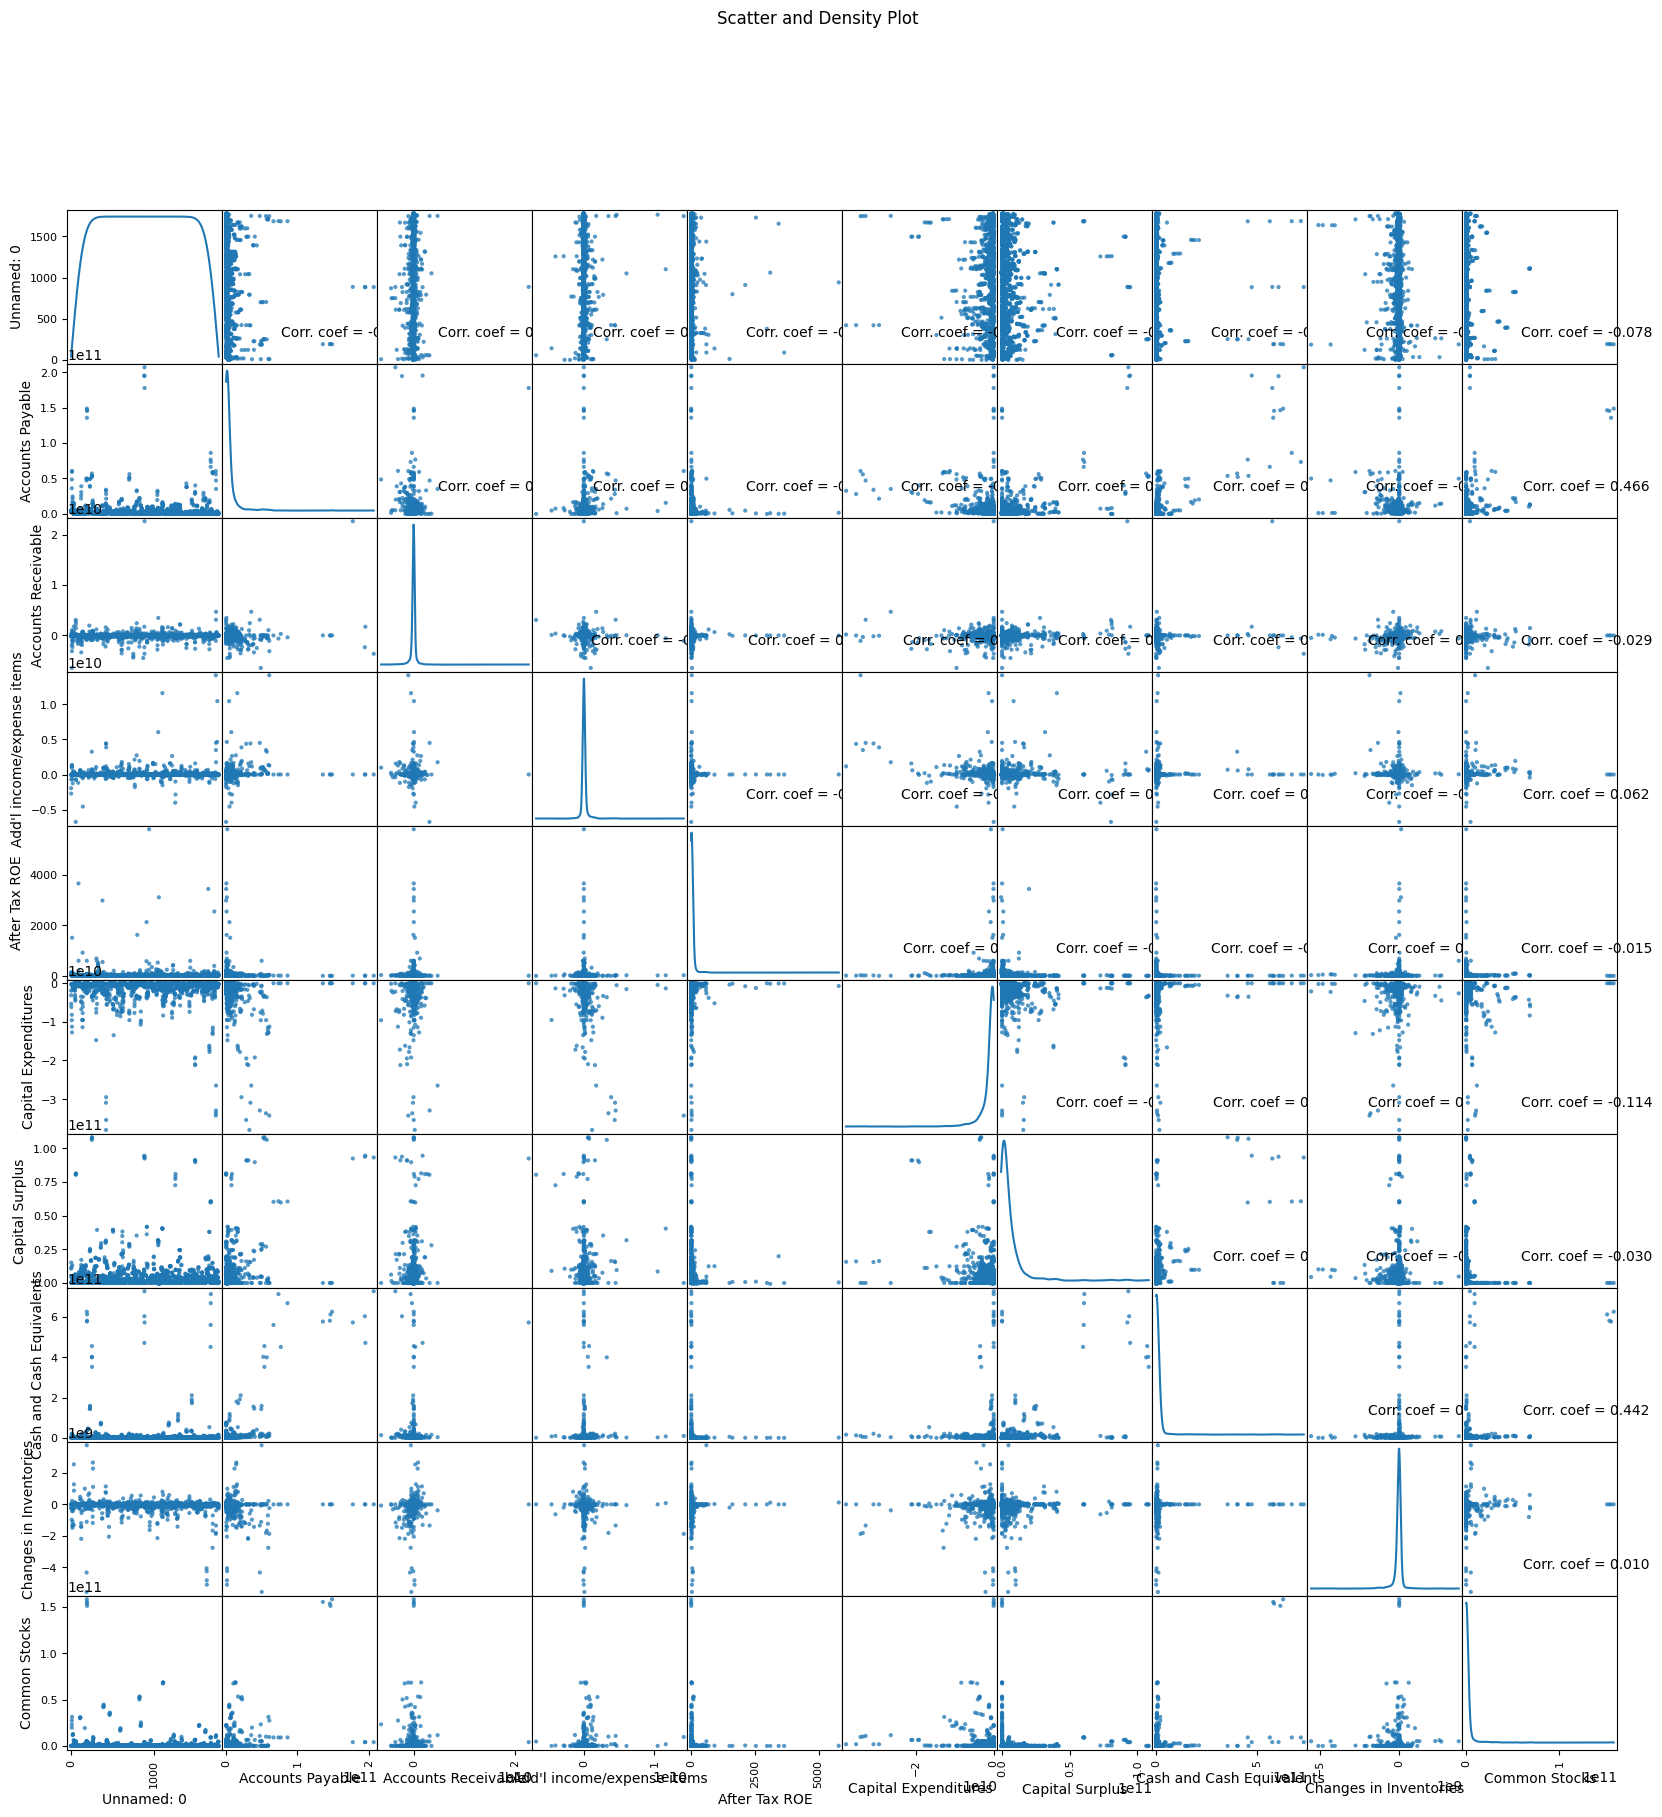

In [11]:
plotScatterMatrix(df1, 20, 10)


In [12]:
import pandas as pd

def remove_highly_correlated_columns(df, threshold=0.8):
    # Compute the correlation matrix
    df = df.select_dtypes(include=[np.number])

    corr_matrix = df.corr().abs()  # Take absolute value to consider both positive and negative correlations
    
    # Select upper triangle of the correlation matrix
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find index of columns with correlation greater than the threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    
    # Drop the columns
    df_reduced = df.drop(columns=to_drop)
    
    print(f"Removed {len(to_drop)} columns with correlation above {threshold}.")
    return df_reduced


In [13]:
df_reduced=remove_highly_correlated_columns(df1)

Removed 29 columns with correlation above 0.8.


In [14]:
df_reduced.shape

(1781, 48)

In [15]:
df2 = pd.read_csv('../input/nyse/prices.csv', delimiter=',')
df2.dataframeName = 'prices.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 851264 rows and 7 columns


In [16]:
df2.head()

date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0

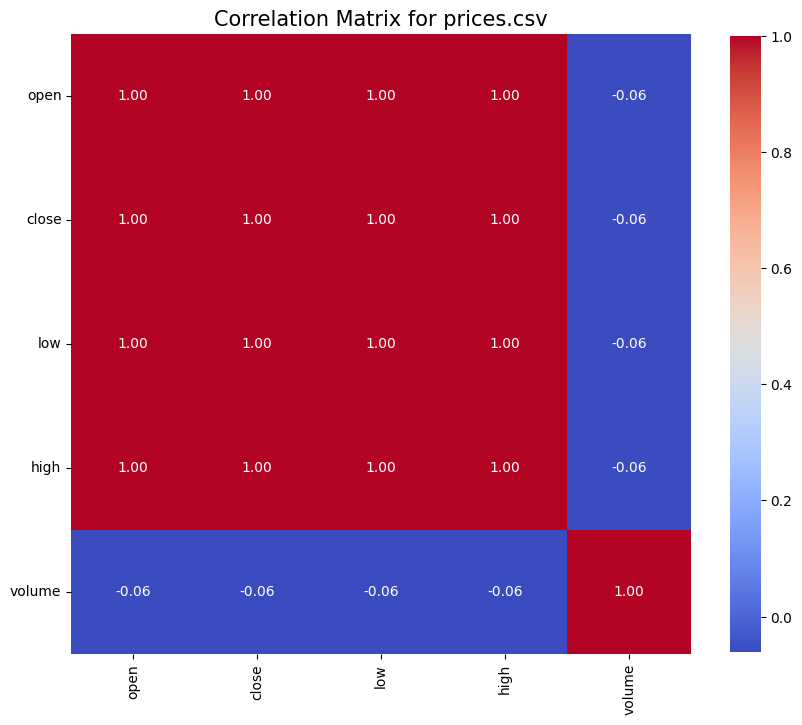

In [17]:
plotCorrelationMatrix(df2, 10)


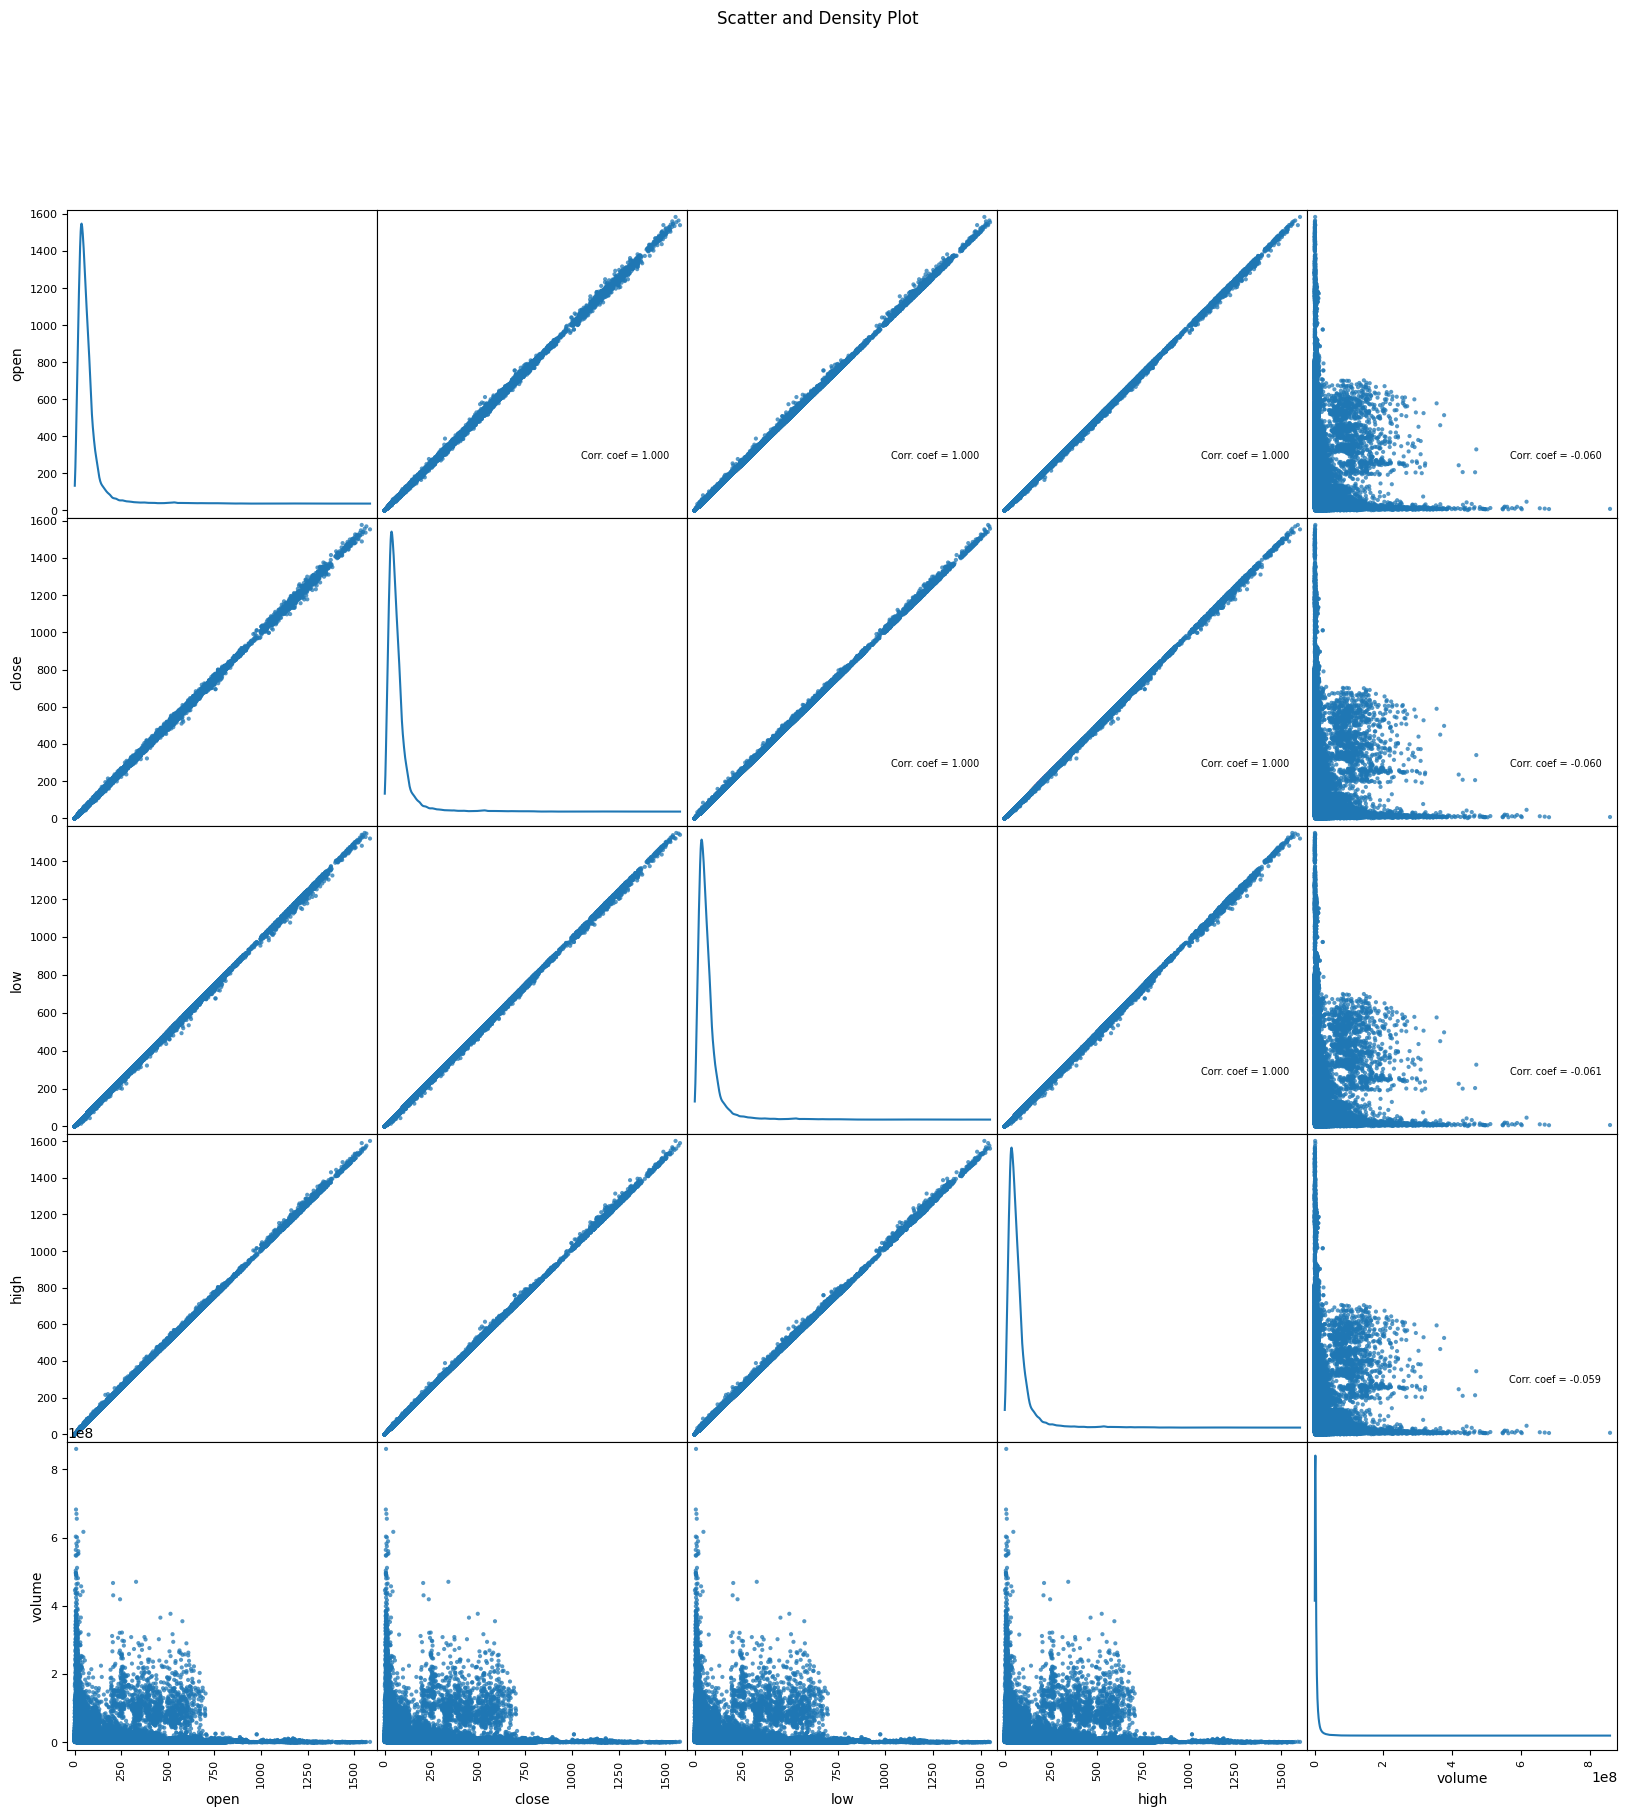

In [18]:
plotScatterMatrix(df2, 20, 7)


In [19]:
# prices-split-adjusted.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df3 = pd.read_csv('../input/nyse/prices-split-adjusted.csv', delimiter=',',nrows = 200000)
df3.dataframeName = 'prices-split-adjusted.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 200000 rows and 7 columns


In [20]:
df3.head()

date symbol        open       close         low        high  \
0  2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0

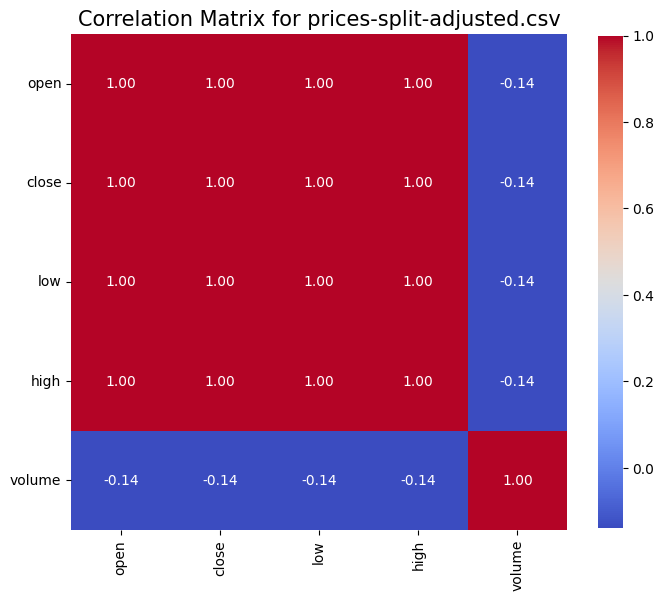

In [21]:
plotCorrelationMatrix(df3, 8)


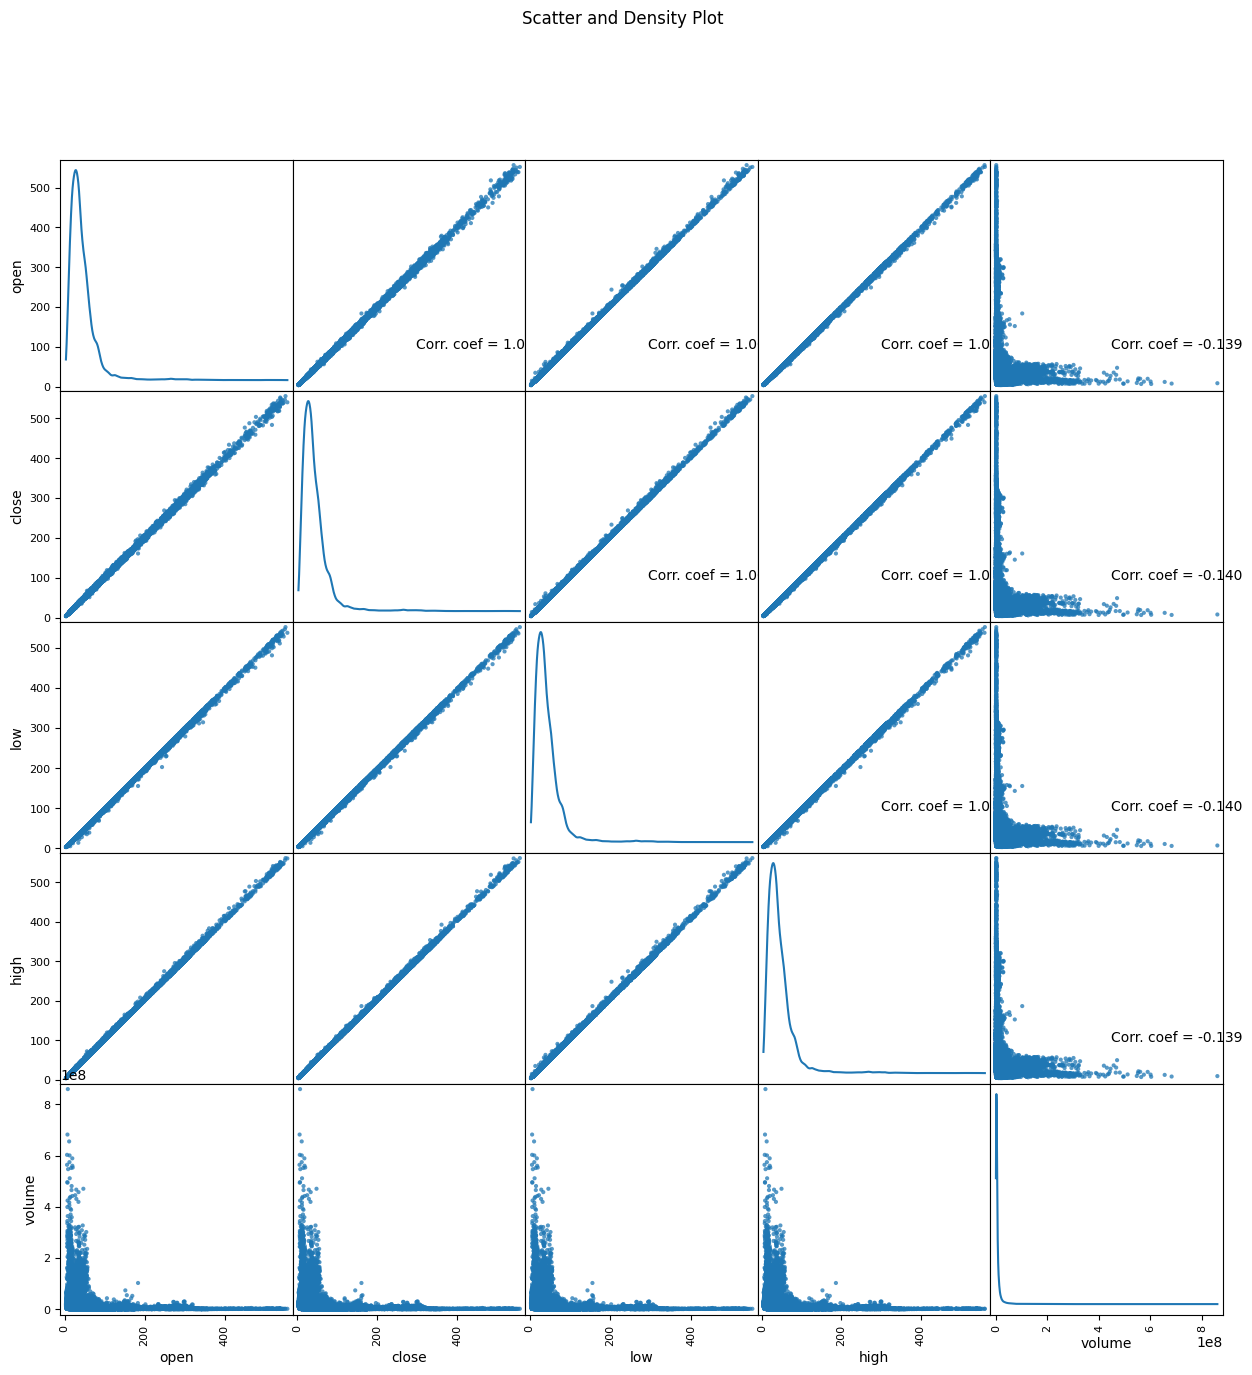

In [22]:
plotScatterMatrix(df3, 15, 10)


In [23]:
class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = Linear(n_inputs, 10)
        xavier_uniform_(self.hidden1.weight)
        self.act1 = Sigmoid()
        
        self.hidden2 = Linear(10, 8)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = Sigmoid()
        
        self.hidden3 = Linear(8, 1)
        xavier_uniform_(self.hidden3.weight)
 
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        
        X = self.hidden2(X)
        X = self.act2(X)
        
        X = self.hidden3(X)
        return X


In [24]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import MSELoss
from torch.optim import SGD
from tqdm import tqdm
import torch

# Utiliser scikit-learn pour préparer les données
def prepare_data_sklearn(X, y, test_size=0.2, batch_size=32):
    # Diviser les données en train et test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Convertir les DataFrames en tensors PyTorch
    X_train, X_test = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(X_test.values, dtype=torch.float32)
    y_train, y_test = torch.tensor(y_train.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)
    
    # Créer des TensorDataset
    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)
    
    # Créer des DataLoader pour PyTorch
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_dl, test_dl
# Fonction pour entraîner le modèle
def train_model(train_dl, model):
    size = len(train_dl.dataset)
    # Définir l'optimiseur et la fonction de perte
    criterion = MSELoss()  # fonction de perte
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    # Boucle d'entraînement
    for epoch in tqdm(range(100), desc='Training Epochs'):
        print(f"Epoch {epoch + 1}\n-------------------------------")
        # Itérer sur les mini-lots
        for batch, (inputs, targets) in enumerate(train_dl):
            # Réinitialiser les gradients
            optimizer.zero_grad()
            # Calculer la sortie du modèle
            yhat = model(inputs)
            # Calculer la perte
            loss = criterion(yhat, targets)
            # Rétropropagation
            loss.backward()
            # Mettre à jour les poids du modèle
            optimizer.step()
        
        # Afficher la perte pour l'époque actuelle
        loss_value = loss.item()
        print(f"loss: {loss_value:>7f}  [Epoch {epoch+1}]")

In [26]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    return mse

In [27]:
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

In [34]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Supposons que df3 est votre DataFrame

# 1. Appliquer LabelEncoder à la colonne 'symbol'
le = LabelEncoder()
df3['symbol'] = le.fit_transform(df3['symbol'])

# 2. Appliquer StandardScaler aux colonnes numériques
scaler = StandardScaler()

# Vous pouvez appliquer le StandardScaler uniquement aux colonnes numériques (ignorer la colonne 'date' si nécessaire)
# Par exemple, vous pouvez appliquer le scaler à toutes les colonnes sauf 'date' et 'symbol'
X = df3.drop(columns=['close','date']).copy()  # Exclure 'date' et 'symbol' de la normalisation
y=df3['close']



In [36]:
train_dl, test_dl = prepare_data_sklearn(X,y)
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = MLP(5)
# train the model
train_model(train_dl, model)

160000 40000


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1
-------------------------------


Training Epochs:   1%|          | 1/100 [00:06<10:59,  6.66s/it]

loss: 253.390839  [Epoch 1]
Epoch 2
-------------------------------


Training Epochs:   2%|▏         | 2/100 [00:13<10:46,  6.59s/it]

loss: 1829.137451  [Epoch 2]
Epoch 3
-------------------------------


Training Epochs:   3%|▎         | 3/100 [00:19<10:40,  6.61s/it]

loss: 2593.545410  [Epoch 3]
Epoch 4
-------------------------------


Training Epochs:   4%|▍         | 4/100 [00:26<10:28,  6.55s/it]

loss: 3061.424316  [Epoch 4]
Epoch 5
-------------------------------


Training Epochs:   5%|▌         | 5/100 [00:32<10:24,  6.58s/it]

loss: 1548.956299  [Epoch 5]
Epoch 6
-------------------------------


Training Epochs:   6%|▌         | 6/100 [00:39<10:18,  6.58s/it]

loss: 507.223694  [Epoch 6]
Epoch 7
-------------------------------


Training Epochs:   7%|▋         | 7/100 [00:45<10:08,  6.54s/it]

loss: 511.374207  [Epoch 7]
Epoch 8
-------------------------------


Training Epochs:   8%|▊         | 8/100 [00:52<10:03,  6.56s/it]

loss: 615.096375  [Epoch 8]
Epoch 9
-------------------------------


Training Epochs:   9%|▉         | 9/100 [00:59<09:57,  6.57s/it]

loss: 3532.496582  [Epoch 9]
Epoch 10
-------------------------------


Training Epochs:  10%|█         | 10/100 [01:05<09:50,  6.56s/it]

loss: 574.093750  [Epoch 10]
Epoch 11
-------------------------------


Training Epochs:  11%|█         | 11/100 [01:12<09:42,  6.54s/it]

loss: 1394.933594  [Epoch 11]
Epoch 12
-------------------------------


Training Epochs:  12%|█▏        | 12/100 [01:18<09:34,  6.53s/it]

loss: 931.715576  [Epoch 12]
Epoch 13
-------------------------------


Training Epochs:  13%|█▎        | 13/100 [01:25<09:27,  6.53s/it]

loss: 753.442993  [Epoch 13]
Epoch 14
-------------------------------


Training Epochs:  14%|█▍        | 14/100 [01:31<09:21,  6.53s/it]

loss: 660.801453  [Epoch 14]
Epoch 15
-------------------------------


Training Epochs:  15%|█▌        | 15/100 [01:38<09:14,  6.52s/it]

loss: 718.737976  [Epoch 15]
Epoch 16
-------------------------------


Training Epochs:  16%|█▌        | 16/100 [01:44<09:06,  6.51s/it]

loss: 2281.581299  [Epoch 16]
Epoch 17
-------------------------------


Training Epochs:  17%|█▋        | 17/100 [01:51<09:00,  6.51s/it]

loss: 816.060120  [Epoch 17]
Epoch 18
-------------------------------


Training Epochs:  18%|█▊        | 18/100 [01:57<08:54,  6.52s/it]

loss: 372.527832  [Epoch 18]
Epoch 19
-------------------------------


Training Epochs:  19%|█▉        | 19/100 [02:04<08:50,  6.55s/it]

loss: 387.285583  [Epoch 19]
Epoch 20
-------------------------------


Training Epochs:  20%|██        | 20/100 [02:10<08:43,  6.54s/it]

loss: 668.561340  [Epoch 20]
Epoch 21
-------------------------------


Training Epochs:  21%|██        | 21/100 [02:17<08:36,  6.54s/it]

loss: 8292.748047  [Epoch 21]
Epoch 22
-------------------------------


Training Epochs:  22%|██▏       | 22/100 [02:24<08:32,  6.58s/it]

loss: 468.110474  [Epoch 22]
Epoch 23
-------------------------------


Training Epochs:  23%|██▎       | 23/100 [02:30<08:25,  6.56s/it]

loss: 1305.325562  [Epoch 23]
Epoch 24
-------------------------------


Training Epochs:  24%|██▍       | 24/100 [02:37<08:17,  6.54s/it]

loss: 859.734314  [Epoch 24]
Epoch 25
-------------------------------


Training Epochs:  25%|██▌       | 25/100 [02:43<08:11,  6.55s/it]

loss: 644.919067  [Epoch 25]
Epoch 26
-------------------------------


Training Epochs:  26%|██▌       | 26/100 [02:50<08:05,  6.56s/it]

loss: 1661.078857  [Epoch 26]
Epoch 27
-------------------------------


Training Epochs:  27%|██▋       | 27/100 [02:56<08:01,  6.59s/it]

loss: 621.063354  [Epoch 27]
Epoch 28
-------------------------------


Training Epochs:  28%|██▊       | 28/100 [03:03<07:54,  6.58s/it]

loss: 552.575073  [Epoch 28]
Epoch 29
-------------------------------


Training Epochs:  29%|██▉       | 29/100 [03:10<07:46,  6.57s/it]

loss: 2134.234619  [Epoch 29]
Epoch 30
-------------------------------


Training Epochs:  30%|███       | 30/100 [03:16<07:39,  6.56s/it]

loss: 3960.881836  [Epoch 30]
Epoch 31
-------------------------------


Training Epochs:  31%|███       | 31/100 [03:23<07:34,  6.58s/it]

loss: 1676.324951  [Epoch 31]
Epoch 32
-------------------------------


Training Epochs:  32%|███▏      | 32/100 [03:30<07:31,  6.64s/it]

loss: 460.809753  [Epoch 32]
Epoch 33
-------------------------------


Training Epochs:  33%|███▎      | 33/100 [03:36<07:22,  6.60s/it]

loss: 836.242737  [Epoch 33]
Epoch 34
-------------------------------


Training Epochs:  34%|███▍      | 34/100 [03:43<07:13,  6.57s/it]

loss: 2857.722412  [Epoch 34]
Epoch 35
-------------------------------


Training Epochs:  35%|███▌      | 35/100 [03:49<07:06,  6.56s/it]

loss: 689.062378  [Epoch 35]
Epoch 36
-------------------------------


Training Epochs:  36%|███▌      | 36/100 [03:56<06:58,  6.53s/it]

loss: 381.980072  [Epoch 36]
Epoch 37
-------------------------------


Training Epochs:  37%|███▋      | 37/100 [04:02<06:52,  6.54s/it]

loss: 3466.688721  [Epoch 37]
Epoch 38
-------------------------------


Training Epochs:  38%|███▊      | 38/100 [04:09<06:44,  6.53s/it]

loss: 703.869751  [Epoch 38]
Epoch 39
-------------------------------


Training Epochs:  39%|███▉      | 39/100 [04:15<06:37,  6.51s/it]

loss: 357.115845  [Epoch 39]
Epoch 40
-------------------------------


Training Epochs:  40%|████      | 40/100 [04:22<06:31,  6.53s/it]

loss: 1103.923340  [Epoch 40]
Epoch 41
-------------------------------


Training Epochs:  41%|████      | 41/100 [04:28<06:25,  6.54s/it]

loss: 2858.126465  [Epoch 41]
Epoch 42
-------------------------------


Training Epochs:  42%|████▏     | 42/100 [04:35<06:20,  6.56s/it]

loss: 463.065491  [Epoch 42]
Epoch 43
-------------------------------


Training Epochs:  43%|████▎     | 43/100 [04:41<06:13,  6.55s/it]

loss: 373.834015  [Epoch 43]
Epoch 44
-------------------------------


Training Epochs:  44%|████▍     | 44/100 [04:48<06:08,  6.58s/it]

loss: 739.123718  [Epoch 44]
Epoch 45
-------------------------------


Training Epochs:  45%|████▌     | 45/100 [04:55<06:01,  6.58s/it]

loss: 2498.972412  [Epoch 45]
Epoch 46
-------------------------------


Training Epochs:  46%|████▌     | 46/100 [05:01<05:58,  6.64s/it]

loss: 2834.016357  [Epoch 46]
Epoch 47
-------------------------------


Training Epochs:  47%|████▋     | 47/100 [05:08<05:52,  6.64s/it]

loss: 549.404175  [Epoch 47]
Epoch 48
-------------------------------


Training Epochs:  48%|████▊     | 48/100 [05:14<05:42,  6.59s/it]

loss: 3831.395508  [Epoch 48]
Epoch 49
-------------------------------


Training Epochs:  49%|████▉     | 49/100 [05:21<05:35,  6.57s/it]

loss: 1767.121948  [Epoch 49]
Epoch 50
-------------------------------


Training Epochs:  50%|█████     | 50/100 [05:28<05:27,  6.56s/it]

loss: 369.285461  [Epoch 50]
Epoch 51
-------------------------------


Training Epochs:  51%|█████     | 51/100 [05:34<05:21,  6.55s/it]

loss: 505.082184  [Epoch 51]
Epoch 52
-------------------------------


Training Epochs:  52%|█████▏    | 52/100 [05:41<05:14,  6.55s/it]

loss: 591.265198  [Epoch 52]
Epoch 53
-------------------------------


Training Epochs:  53%|█████▎    | 53/100 [05:47<05:06,  6.52s/it]

loss: 390.184692  [Epoch 53]
Epoch 54
-------------------------------


Training Epochs:  54%|█████▍    | 54/100 [05:54<05:00,  6.53s/it]

loss: 425.295746  [Epoch 54]
Epoch 55
-------------------------------


Training Epochs:  55%|█████▌    | 55/100 [06:00<04:54,  6.54s/it]

loss: 423.281494  [Epoch 55]
Epoch 56
-------------------------------


Training Epochs:  56%|█████▌    | 56/100 [06:07<04:49,  6.58s/it]

loss: 2449.074219  [Epoch 56]
Epoch 57
-------------------------------


Training Epochs:  57%|█████▋    | 57/100 [06:13<04:41,  6.55s/it]

loss: 797.549438  [Epoch 57]
Epoch 58
-------------------------------


Training Epochs:  58%|█████▊    | 58/100 [06:20<04:35,  6.55s/it]

loss: 994.686523  [Epoch 58]
Epoch 59
-------------------------------


Training Epochs:  59%|█████▉    | 59/100 [06:26<04:28,  6.55s/it]

loss: 454.402435  [Epoch 59]
Epoch 60
-------------------------------


Training Epochs:  60%|██████    | 60/100 [06:33<04:22,  6.57s/it]

loss: 744.697754  [Epoch 60]
Epoch 61
-------------------------------


Training Epochs:  61%|██████    | 61/100 [06:40<04:16,  6.57s/it]

loss: 1857.080322  [Epoch 61]
Epoch 62
-------------------------------


Training Epochs:  62%|██████▏   | 62/100 [06:46<04:08,  6.55s/it]

loss: 2372.129150  [Epoch 62]
Epoch 63
-------------------------------


Training Epochs:  63%|██████▎   | 63/100 [06:53<04:02,  6.55s/it]

loss: 955.188843  [Epoch 63]
Epoch 64
-------------------------------


Training Epochs:  64%|██████▍   | 64/100 [06:59<03:55,  6.55s/it]

loss: 667.195068  [Epoch 64]
Epoch 65
-------------------------------


Training Epochs:  65%|██████▌   | 65/100 [07:06<03:48,  6.54s/it]

loss: 3455.957275  [Epoch 65]
Epoch 66
-------------------------------


Training Epochs:  66%|██████▌   | 66/100 [07:12<03:43,  6.58s/it]

loss: 846.355042  [Epoch 66]
Epoch 67
-------------------------------


Training Epochs:  67%|██████▋   | 67/100 [07:19<03:36,  6.57s/it]

loss: 426.718048  [Epoch 67]
Epoch 68
-------------------------------


Training Epochs:  68%|██████▊   | 68/100 [07:25<03:29,  6.53s/it]

loss: 384.393463  [Epoch 68]
Epoch 69
-------------------------------


Training Epochs:  69%|██████▉   | 69/100 [07:32<03:22,  6.54s/it]

loss: 620.894470  [Epoch 69]
Epoch 70
-------------------------------


Training Epochs:  70%|███████   | 70/100 [07:39<03:16,  6.56s/it]

loss: 1483.188110  [Epoch 70]
Epoch 71
-------------------------------


Training Epochs:  71%|███████   | 71/100 [07:45<03:09,  6.53s/it]

loss: 8487.447266  [Epoch 71]
Epoch 72
-------------------------------


Training Epochs:  72%|███████▏  | 72/100 [07:52<03:02,  6.52s/it]

loss: 583.048706  [Epoch 72]
Epoch 73
-------------------------------


Training Epochs:  73%|███████▎  | 73/100 [07:58<02:55,  6.52s/it]

loss: 490.024231  [Epoch 73]
Epoch 74
-------------------------------


Training Epochs:  74%|███████▍  | 74/100 [08:05<02:49,  6.51s/it]

loss: 1077.525513  [Epoch 74]
Epoch 75
-------------------------------


Training Epochs:  75%|███████▌  | 75/100 [08:11<02:43,  6.54s/it]

loss: 803.380615  [Epoch 75]
Epoch 76
-------------------------------


Training Epochs:  76%|███████▌  | 76/100 [08:18<02:37,  6.56s/it]

loss: 487.569000  [Epoch 76]
Epoch 77
-------------------------------


Training Epochs:  77%|███████▋  | 77/100 [08:24<02:30,  6.55s/it]

loss: 1883.163574  [Epoch 77]
Epoch 78
-------------------------------


Training Epochs:  78%|███████▊  | 78/100 [08:31<02:24,  6.56s/it]

loss: 436.522461  [Epoch 78]
Epoch 79
-------------------------------


Training Epochs:  79%|███████▉  | 79/100 [08:37<02:17,  6.54s/it]

loss: 469.741913  [Epoch 79]
Epoch 80
-------------------------------


Training Epochs:  80%|████████  | 80/100 [08:44<02:11,  6.58s/it]

loss: 639.978394  [Epoch 80]
Epoch 81
-------------------------------


Training Epochs:  81%|████████  | 81/100 [08:51<02:04,  6.56s/it]

loss: 651.195862  [Epoch 81]
Epoch 82
-------------------------------


Training Epochs:  82%|████████▏ | 82/100 [08:57<01:57,  6.52s/it]

loss: 2512.707275  [Epoch 82]
Epoch 83
-------------------------------


Training Epochs:  83%|████████▎ | 83/100 [09:03<01:49,  6.42s/it]

loss: 4244.163574  [Epoch 83]
Epoch 84
-------------------------------


Training Epochs:  84%|████████▍ | 84/100 [09:09<01:41,  6.37s/it]

loss: 414.257538  [Epoch 84]
Epoch 85
-------------------------------


Training Epochs:  85%|████████▌ | 85/100 [09:16<01:35,  6.36s/it]

loss: 1289.659790  [Epoch 85]
Epoch 86
-------------------------------


Training Epochs:  86%|████████▌ | 86/100 [09:22<01:29,  6.38s/it]

loss: 986.880249  [Epoch 86]
Epoch 87
-------------------------------


Training Epochs:  87%|████████▋ | 87/100 [09:29<01:22,  6.37s/it]

loss: 1002.067932  [Epoch 87]
Epoch 88
-------------------------------


Training Epochs:  88%|████████▊ | 88/100 [09:35<01:16,  6.34s/it]

loss: 531.524353  [Epoch 88]
Epoch 89
-------------------------------


Training Epochs:  89%|████████▉ | 89/100 [09:41<01:09,  6.33s/it]

loss: 708.505005  [Epoch 89]
Epoch 90
-------------------------------


Training Epochs:  90%|█████████ | 90/100 [09:47<01:03,  6.34s/it]

loss: 996.124329  [Epoch 90]
Epoch 91
-------------------------------


Training Epochs:  91%|█████████ | 91/100 [09:54<00:56,  6.29s/it]

loss: 1542.419922  [Epoch 91]
Epoch 92
-------------------------------


Training Epochs:  92%|█████████▏| 92/100 [10:00<00:50,  6.29s/it]

loss: 2808.225586  [Epoch 92]
Epoch 93
-------------------------------


Training Epochs:  93%|█████████▎| 93/100 [10:06<00:44,  6.29s/it]

loss: 432.830933  [Epoch 93]
Epoch 94
-------------------------------


Training Epochs:  94%|█████████▍| 94/100 [10:13<00:37,  6.33s/it]

loss: 1274.736816  [Epoch 94]
Epoch 95
-------------------------------


Training Epochs:  95%|█████████▌| 95/100 [10:19<00:31,  6.36s/it]

loss: 595.709229  [Epoch 95]
Epoch 96
-------------------------------


Training Epochs:  96%|█████████▌| 96/100 [10:25<00:25,  6.35s/it]

loss: 1253.607666  [Epoch 96]
Epoch 97
-------------------------------


Training Epochs:  97%|█████████▋| 97/100 [10:32<00:19,  6.34s/it]

loss: 431.285767  [Epoch 97]
Epoch 98
-------------------------------


Training Epochs:  98%|█████████▊| 98/100 [10:38<00:12,  6.33s/it]

loss: 8164.812500  [Epoch 98]
Epoch 99
-------------------------------


Training Epochs:  99%|█████████▉| 99/100 [10:44<00:06,  6.31s/it]

loss: 848.969055  [Epoch 99]
Epoch 100
-------------------------------


Training Epochs: 100%|██████████| 100/100 [10:51<00:00,  6.51s/it]

loss: 631.318604  [Epoch 100]
